# 📊 접근 로그 분석 노트북

**분석 대상**: `suwon_portal` (수원시 내부 포털 접근 로그)

---

## 1. 환경 설정

In [1]:
import warnings
warnings.filterwarnings("ignore")
# ===== 경로 설정 (ModuleNotFoundError 방지) =====
import sys
import os
ABS_PATH = "/DATA/jupyter_WorkingDirectory/notebook/Access_Analysis"
if ABS_PATH not in sys.path:
    sys.path.append(ABS_PATH)

# ===== Autoreload 설정 =====
%reload_ext autoreload

import os

import matplotlib as mpl

# ===== 시각화 설정 (Robust Font Fix) =====
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np

# ===== 기본 라이브러리 =====
import pandas as pd
import seaborn as sns

# ===== DB 유틸리티 =====
try:
    from db_utils import get_dataframe, get_tables, list_databases, preview, save_dataframe
except ModuleNotFoundError:
    print(f"Error: db_utils not found in sys.path. Current paths: {sys.path}")
    raise

font_path = "/usr/share/fonts/noto/NotoSansCJKkr-Regular.otf"
if os.path.exists(font_path):
    fm.fontManager.addfont(font_path)
    prop = fm.FontProperties(fname=font_path)
    plt.rcParams["font.family"] = prop.get_name()
    print(f"Font successfully set to: {prop.get_name()}")
else:
    print("Warning: Font file not found. Falling back to default.")

plt.rcParams["axes.unicode_minus"] = False
sns.set_theme(style="whitegrid", font=plt.rcParams["font.family"])

# ===== pandas 출력 설정 =====
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.width", None)

Font successfully set to: Noto Sans CJK KR


In [2]:
# 사용 가능한 DB 목록 확인
list_databases()
# ========================================
# 🔧 이 셀만 수정하면 다른 DB로 전환 가능
# ========================================
DB_ALIAS = "suwon_platform"  # db_config.json에 정의된 DB 별칭

사용 가능한 데이터베이스 목록

📦 koroad_portal
   유형: postgresql
   DB명: da
   설명: 한국도로공사 내부 포털 접근 로그 DB

📦 koroad_kiosk
   유형: mariadb
   DB명: koroad
   설명: 한국도로공사 키오스크 접근 로그 DB

📦 suwon_platform
   유형: postgresql
   DB명: suwon
   설명: 수원시 내부 포털 접근 로그 DB

📦 suwon_portal
   유형: postgresql
   DB명: postgres
   설명: 수원시 외부 포털 접근 로그 DB



## 2. 데이터 로드 및 전처리

In [3]:
# 테이블 목록 확인
tables = get_tables(DB_ALIAS)
tables.head()

,table_name,table_type
0,A_기후,BASE TABLE
1,A_위치,BASE TABLE
2,A_토지,BASE TABLE
3,access_record,BASE TABLE
4,access_record_prod,BASE TABLE


In [4]:
# ===== 데이터 로드 및 운영자/일반 사용자 분리 =====
acc_query = """
            SELECT *
            FROM public.access_record_prod
            """

rss_query = """
            SELECT *
            FROM public.resource_prod
            """

acc_log = get_dataframe(DB_ALIAS, acc_query)
rss = get_dataframe(DB_ALIAS, rss_query)

# ===== 운영자 및 일반 사용자 분리 (Data Cleansing) =====
TOTAL_USERS = 5000
OPERATOR_ID = "pebble"

# 1. 운영자 로그 분리
op_log = acc_log[acc_log["user_id"] == OPERATOR_ID].copy()

# 2. 일반 사용자 로그 분리 (운영자 및 인턴 계정 제외)
# 'pebble' 제외 및 'intern' 포함 계정 제외 (대소문자 무시)
is_intern = acc_log["user_id"].str.contains("intern", case=False, na=False)
is_operator = acc_log["user_id"] == OPERATOR_ID

user_log = acc_log[~(is_operator | is_intern)].copy()
intern_log = acc_log[is_intern & ~is_operator].copy()

# 기본 분석 대상 설정 (일반 사용자 위주)
df = user_log

print(f"전체 로그: {acc_log.shape[0]:,}행")
print(
    f"일반 사용자 로그: {user_log.shape[0]:,}행 (고유 {user_log['user_id'].nunique():,}명)"
)
print(f"운영자({OPERATOR_ID}) 로그: {op_log.shape[0]:,}행")
print(
    f"인턴 계정 로그: {intern_log.shape[0]:,}행 (고유 {intern_log['user_id'].nunique():,}명) -> 분석 제외"
)

전체 로그: 1,331,224행
일반 사용자 로그: 684,787행 (고유 779명)
운영자(pebble) 로그: 508,052행
인턴 계정 로그: 138,385행 (고유 14명) -> 분석 제외


## 3. 데이터 탐색 (EDA)

In [5]:
# 데이터 타입 및 결측치 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 684787 entries, 30 to 1331223
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   sequence   684787 non-null  int64         
 1   user_id    684787 non-null  object        
 2   page_url   684787 non-null  object        
 3   page_name  684787 non-null  object        
 4   ip_info    684787 non-null  object        
 5   flag       684787 non-null  int64         
 6   issuer     684787 non-null  object        
 7   issued     684787 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 47.0+ MB


In [6]:
# 여기에 분석 코드 작성
df["page_name"].value_counts()

page_name
                         301770
지표 조회                    222243
데이터셋 등록                   73434
분류 항목 등록                  28890
지표조회                      28875
데이터셋 신규등록                 10761
빅데이터 분석                    5614
로그인                         939
위경도 변환                      914
Role-사용자 매핑 설정              891
카테고리신청                      769
Role-메뉴설정                   683
지표외부연동-DB                   636
로그아웃                        635
지표 등록 - 수동                  632
Role-메뉴 매핑 설정               494
데이터 맵                       458
공지사항                        417
지표외부연동-API                  412
사용자 현황                      389
보고서 URL 관리                  333
메뉴 관리                       312
사전 목록                       308
조직 목록                       302
지표 수동등록                     296
메뉴관리                        296
데이터관리                       283
임시사용자 관리                    267
리소스 사용률                     250
표준어사전                       244
사용자 목록                      23

In [7]:
df[
    (df["page_url"].str.contains("/dataservice/detail/"))
    # &(df['page_name']=='데이터셋')
]

,sequence,user_id,page_url,page_name,ip_info,flag,issuer,issued
30,1331612,ch1177,/dataservice/detail/dataset,,105.1.84.231,0,system,2025-12-31 16:03:19.126
31,1331611,ch1177,/dataservice/detail/ad710ce0-888d-42ea-9648-c0...,,105.1.84.231,0,system,2025-12-31 16:03:19.108
35,1331607,ch1177,/dataservice/detail/ad710ce0-888d-42ea-9648-c0...,,105.1.84.231,0,system,2025-12-31 16:03:12.747
37,1331605,ch1177,/dataservice/detail/dataset,,105.1.84.231,0,system,2025-12-31 16:03:05.019
38,1331604,ch1177,/dataservice/detail/dataset,,105.1.84.231,0,system,2025-12-31 16:03:00.275
...,...,...,...,...,...,...,...,...
1324810,6415,1002265,/dataservice/detail/459e9c33-8c77-4e81-aedc-99...,,::1,0,system,2020-01-14 14:48:11.438
1324816,6409,1002265,/dataservice/detail/459e9c33-8c77-4e81-aedc-99...,,::1,0,system,2020-01-14 14:47:24.240
1324866,6359,1002265,/dataservice/detail/9ed5eb19-a8c0-412c-97c8-b1...,,::1,0,system,2020-01-14 14:40:15.320
1324872,6353,1002265,/dataservice/detail/9ed5eb19-a8c0-412c-97c8-b1...,,::1,0,system,2020-01-14 14:40:08.459


In [8]:
rss.head()

,identifier,type,contact_point,keyword,landing_page,qualified_relation,theme,conforms_to,is_referenced_by,creator,description,issued,language,license,modified,publisher,relation,title,has_policy,qualified_attribution,extension,access_rights,rights
0,5b4ca4b8-7dcf-4fd4-a4a5-777577784812,dataset,56100300123,,http://105.1.2.177:28081/dataservice/detail?id...,,23b71c31-7961-416f-9672-7d5d26866e21,pebble,-,pebble,도시교통정보센터 교통 돌발 정보\nhttps://www.utic.go.kr/guid...,2025-12-31 23:01:13.248,KR,Creative Commons,NaT,pebble,None,전국 교통 돌발 정보 2025년 12월 31일 22시 - 1,None,56100300123,,public,Copyright 2025. Suwon City. all rights reserved
1,7e0ee779-702e-4534-8526-ffba9264b9bf,dataset,10144,,http://192.168.102.167:8080/dataservice/ec39b4...,,92e5d5b6-73d2-4f79-bbab-f6672ee73d2f,10144,heeyaa38,undefined,,2025-12-31 23:01:03.485,KR,Creative Commons,NaT,10144,None,환경 미세 먼지 20251231230100 - 1,None,,,public,Copyright 2025. Suwon City. all rights reserved
2,4d96327c-0c07-4f8f-a081-53ef38710c8d,dataset,56100300123,,http://105.1.2.177:28081/dataservice/detail?id...,,0863e892-d327-4372-bda8-2d8e65c02c79,pebble,-,pebble,빅데이터 포털 재난 안전용 지표\n빅데이터팀 내부적으로 받아온 재난 안전 API...,2025-12-31 23:01:03.417,KR,Creative Commons,NaT,pebble,None,수원시 소방 화재 정보 2025년 12월 31일 22시 - 1,None,56100300123,,public,Copyright 2025. Suwon City. all rights reserved
3,6a3777f7-57a6-435b-b714-963c8f46d9f7,dataset,56100300123,,http://105.1.2.177:28081/dataservice/detail?id...,,23b71c31-7961-416f-9672-7d5d26866e21,pebble,-,pebble,http://105.1.2.177:28081/dataservice/detail?id...,2025-12-31 23:01:02.714,KR,Creative Commons,NaT,pebble,None,수원시 교량 현황 표준_2 20251231230100 - 1,None,56100300123,,public,Copyright 2025. Suwon City. all rights reserved
4,91d1f478-078c-48ed-896e-176f377f76ce,dataset,56100300123,,http://105.1.2.177:28081/dataservice/detail?id...,,0863e892-d327-4372-bda8-2d8e65c02c79,pebble,-,pebble,빅데이터 포털 재난 안전용 지표\n빅데이터팀 내부적으로 받아온 재난 안전 API...,2025-12-31 23:01:02.443,KR,Creative Commons,NaT,pebble,None,수원시 소방 긴급 구조 정보 실시간 2025년 12월 31일 22시 - 1,None,56100300123,,public,Copyright 2025. Suwon City. all rights reserved


In [9]:
df[df["page_url"].str.contains("/dataservice/detail")]["page_url"].str.split("/").str[
    -1
].value_counts()

page_url
detail                                  66747
dataset                                 65787
60482079-d6b4-4e8c-bee3-abfcdd5461d1     2967
9c183aea-440c-4447-ad2c-9ab10f972bce     2875
e26dad41-4794-43ff-b759-d5ced1f2439e     2462
                                        ...  
12e45b98-5164-46bf-a159-789b70e0436f        1
31c2d1fe-e033-4544-8899-300039b72971        1
7a84bbfb-6780-4a74-a27a-5401710eb43c        1
5f5d3a38-abe3-4a3c-92fe-fe00b9e196a4        1
e7481b57-d124-4d55-a865-c59a8fcce180        1
Name: count, Length: 1880, dtype: int64

## 4. 활성 사용자 분석 (Active User Analysis)

전체 기간에 걸친 DAU, WAU, MAU 추세를 분석하여 서비스의 성장성과 견고함을 확인합니다.

In [10]:
# 활성 지표 계산 (DAU, WAU, MAU)
df['date'] = df['issued'].dt.date
df['week_start'] = df['issued'].dt.to_period('W').apply(lambda r: r.start_time)
df['month_start'] = df['issued'].dt.to_period('M').apply(lambda r: r.start_time)

# 사용자 통계
dau = df.groupby('date')['user_id'].nunique()
wau = df.groupby('week_start')['user_id'].nunique()
mau = df.groupby('month_start')['user_id'].nunique()

print(f"--- 일반 사용자 (User) 통계 ---")
print(f"평균 DAU: {dau.mean():.1f}명")
print(f"평균 WAU: {wau.mean():.1f}명")
print(f"평균 MAU: {mau.mean():.1f}명")
print(f"최근 MAU: {mau.iloc[-1]:.1f}명")
print(f"고착도 (Stickiness, DAU/MAU): {dau.mean()/mau.mean()*100:.2f}%")

--- 일반 사용자 (User) 통계 ---
평균 DAU: 4.0명
평균 WAU: 10.6명
평균 MAU: 27.6명
최근 MAU: 31.0명
고착도 (Stickiness, DAU/MAU): 14.35%


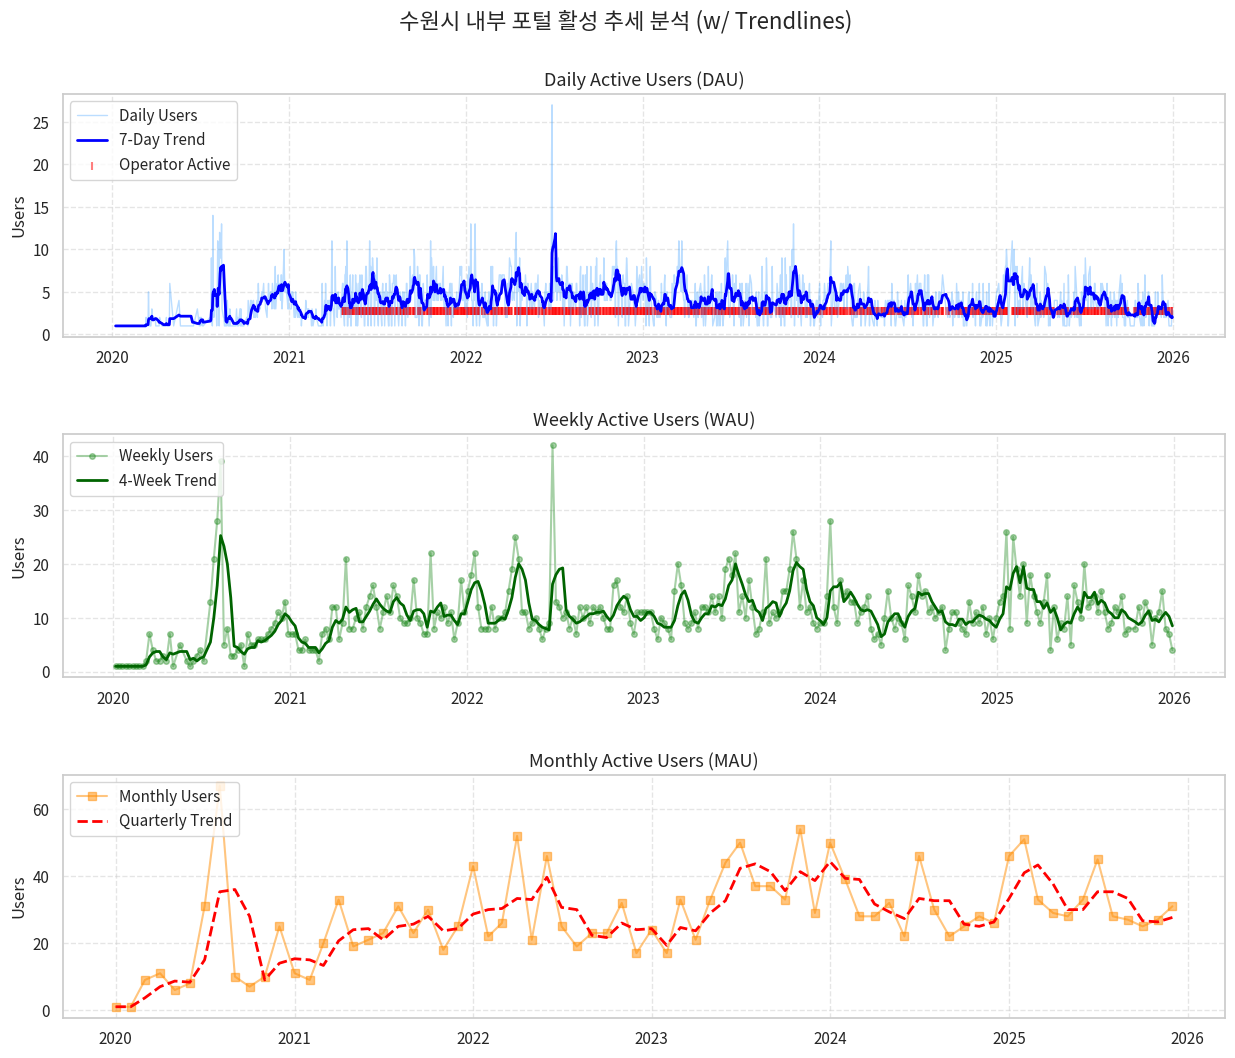

In [11]:
# 3단 추세 시각화 (DAU, WAU, MAU) + 추세선 추가
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=False)
plt.subplots_adjust(hspace=0.4)

# 1. DAU (7일 이동 평균 추가)
axes[0].plot(dau.index, dau.values, label="Daily Users", color="dodgerblue", alpha=0.3, linewidth=1)
axes[0].plot(dau.index, dau.rolling(window=7, min_periods=1).mean(), 
            label="7-Day Trend", color="blue", linewidth=2)
if not op_log.empty:
    op_active_days = op_log["issued"].dt.date.unique()
    axes[0].scatter(op_active_days, [dau.max() * 0.1] * len(op_active_days), 
                color="red", marker="|", label="Operator Active", alpha=0.5)
axes[0].set_title("Daily Active Users (DAU)", fontsize=13)
axes[0].set_ylabel("Users")
axes[0].legend(loc="upper left")
axes[0].grid(True, linestyle="--", alpha=0.5)

# 2. WAU (4주 이동 평균 추가)
axes[1].plot(wau.index, wau.values, label="Weekly Users", color="forestgreen", marker='o', markersize=4, alpha=0.4)
axes[1].plot(wau.index, wau.rolling(window=4, min_periods=1).mean(), 
            label="4-Week Trend", color="darkgreen", linewidth=2)
axes[1].set_title("Weekly Active Users (WAU)", fontsize=13)
axes[1].set_ylabel("Users")
axes[1].legend(loc="upper left")
axes[1].grid(True, linestyle="--", alpha=0.5)

# 3. MAU (선형 추세선 또는 단순 추세 표시)
axes[2].plot(mau.index, mau.values, label="Monthly Users", color="darkorange", marker='s', alpha=0.5)
# MAU는 데이터 포인트가 적으므로 전체 추세를 보기 위해 더 넓은 윈도우 사용
axes[2].plot(mau.index, mau.rolling(window=3, min_periods=1).mean(), 
            label="Quarterly Trend", color="red", linewidth=2, linestyle='--')
axes[2].set_title("Monthly Active Users (MAU)", fontsize=13)
axes[2].set_ylabel("Users")
axes[2].legend(loc="upper left")
axes[2].grid(True, linestyle="--", alpha=0.5)

plt.suptitle("수원시 내부 포털 활성 추세 분석 (w/ Trendlines)", fontsize=16, y=0.95)
plt.show()

### 4.2 분석 결과 및 인사이트 (활성 사용자)

- **성장성**: (차트를 확인하여 DAU/WAU/MAU의 우상향 여부 기록)
- **안정성**: WAU와 MAU의 변동폭을 통해 유저 유입의 안정성 확인
- **특이점**: DAU가 급증하거나 급감한 특정 일자의 이벤트 역추적 필요

## 5. 리텐션 분석 고도화 (Yearly-Monthly Cohort)

주간 단위보다 거시적인 트렌드를 파악하기 위해 연도별/월간 코호트 리텐션을 분석합니다.

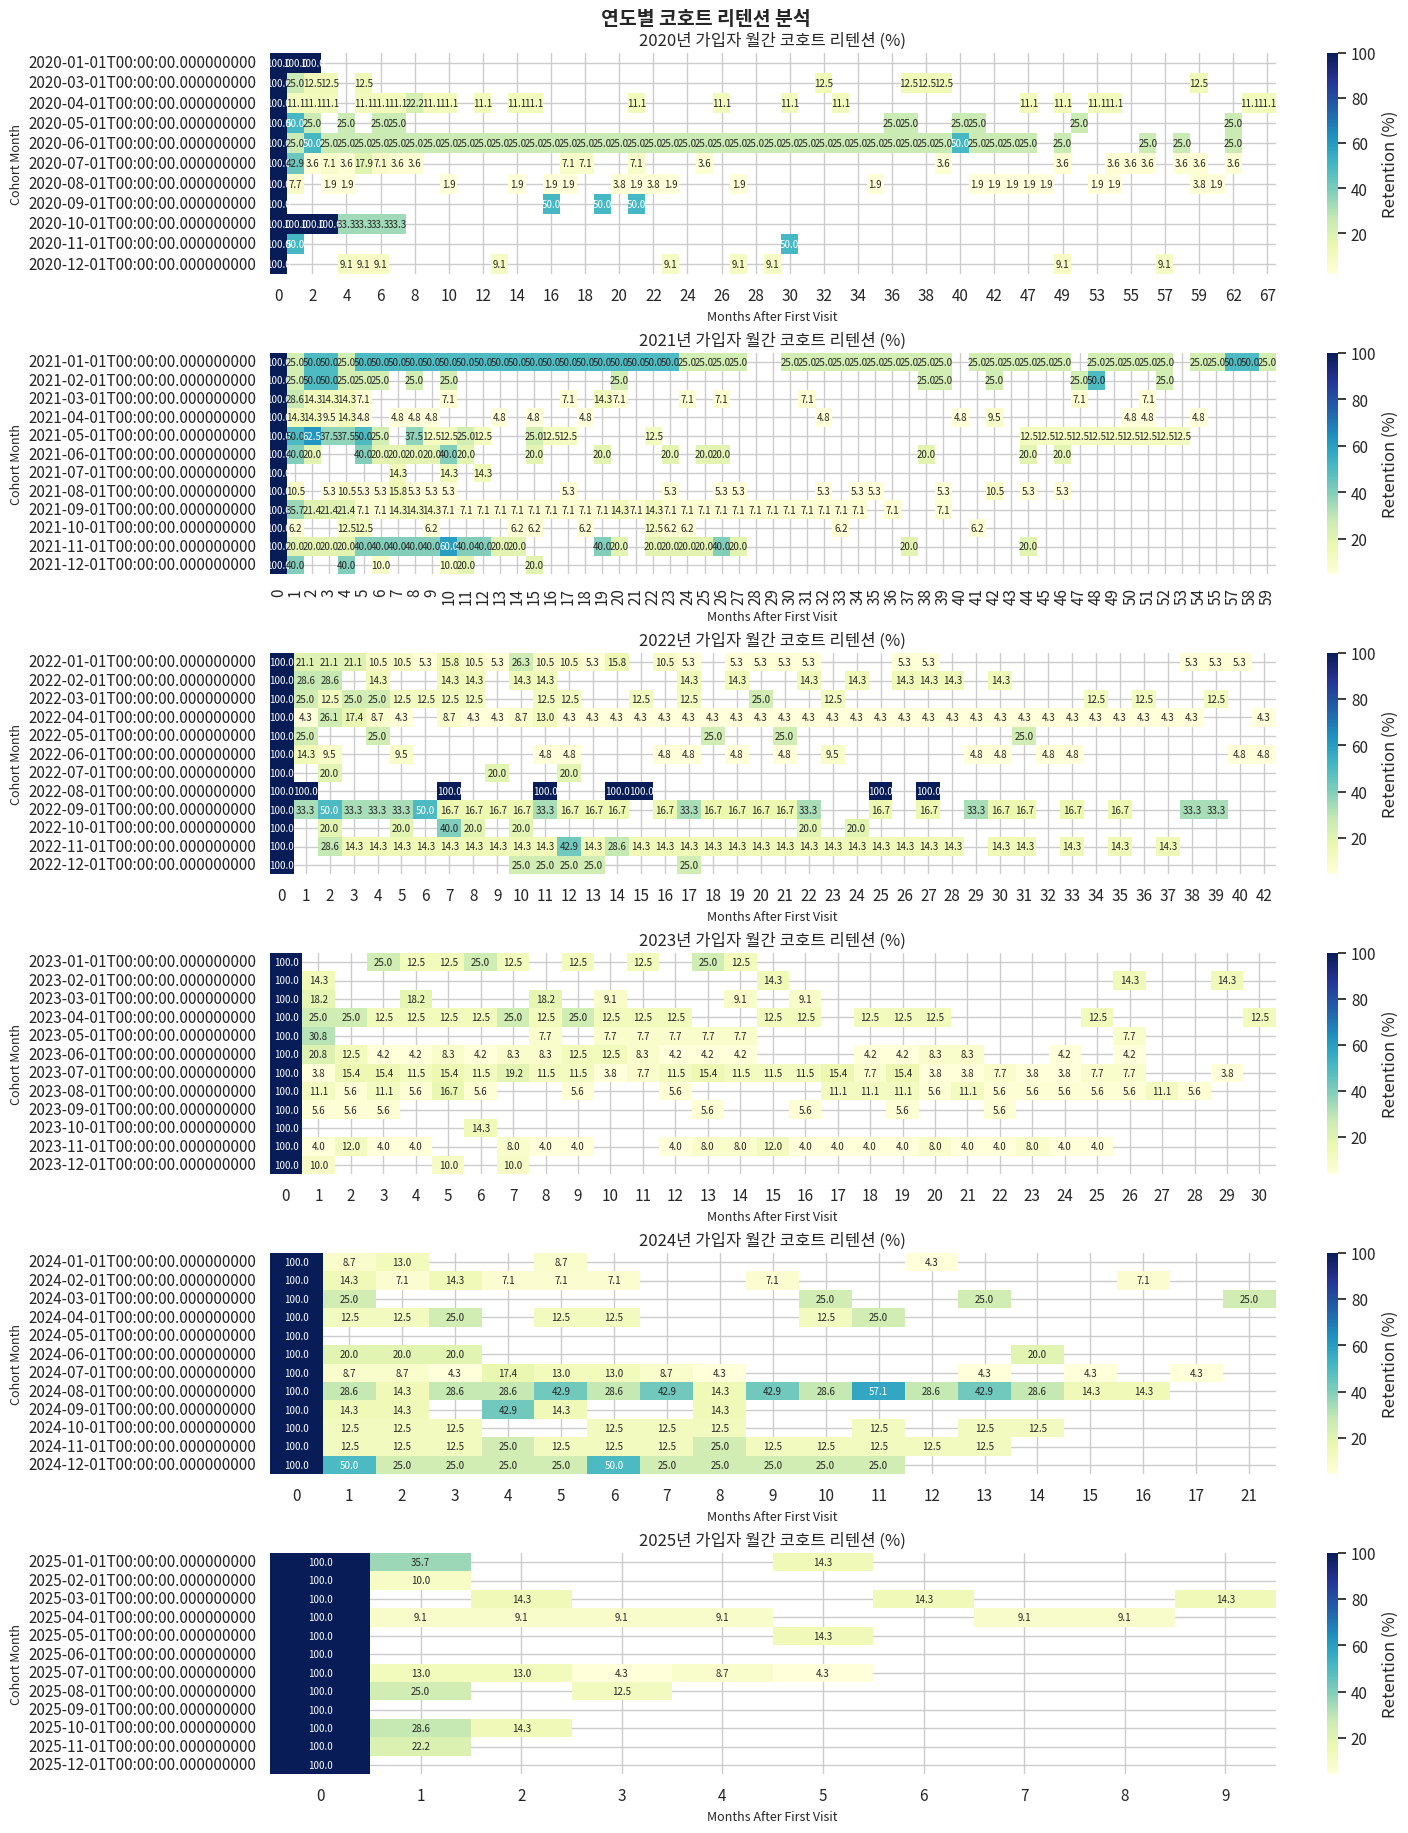

In [12]:
# 연도-월별 코호트 리텐션 시각화 (Subplots)
def plot_monthly_retention(df):
    df = df.copy()
    df['month_start'] = df['issued'].dt.to_period('M').apply(lambda r: r.start_time)
    df['first_month'] = df.groupby('user_id')['month_start'].transform('min')
    df['cohort_month_idx'] = ((df['month_start'].dt.year - df['first_month'].dt.year) * 12 + 
                              (df['month_start'].dt.month - df['first_month'].dt.month))
    
    # 인사이트 분석을 위해 리텐션 매트릭스를 전역 변수로 저장 (0~1 범위)
    global retention
    cohort_pivot_all = df.pivot_table(index='first_month', columns='cohort_month_idx', values='user_id', aggfunc='nunique')
    retention = cohort_pivot_all.divide(cohort_pivot_all.iloc[:, 0], axis=0)

    df['year'] = df['first_month'].dt.year.astype(str)
    years = sorted(df['year'].unique())
    n_years = len(years)
    
    fig, axes = plt.subplots(n_years, 1, figsize=(14, 3 * n_years), constrained_layout=True)
    if n_years == 1:
        axes = [axes]
    
    for ax, y in zip(axes, years):
        y_df = df[df['year'] == y]
        cohort_pivot = y_df.pivot_table(index='first_month', columns='cohort_month_idx', values='user_id', aggfunc='nunique')
        if cohort_pivot.empty:
            continue
        cohort_size = cohort_pivot.iloc[:, 0]
        retention_matrix = cohort_pivot.divide(cohort_size, axis=0) * 100
        
        sns.heatmap(retention_matrix, annot=True, fmt='.1f', cmap='YlGnBu', cbar_kws={'label': 'Retention (%)'}, ax=ax, annot_kws={'size': 7})
        ax.set_title(f'{y}년 가입자 월간 코호트 리텐션 (%)', fontsize=12)
        ax.set_xlabel('Months After First Visit', fontsize=9)
        ax.set_ylabel('Cohort Month', fontsize=9)
    
    plt.suptitle('연도별 코호트 리텐션 분석', fontsize=14, fontweight='bold', y=1.01)
    plt.show()

plot_monthly_retention(df)

### 5.2 리텐션 인사이트

- **연도별 차이**: 특정 연도 가입자의 유지력이 다른 연도 대비 높은지 확인
- **Dead Zone**: 리텐션이 급격히 떨어지는 시점(보통 1~2개월 차)을 파악하여 대응책 마련

In [13]:
import pandas as pd
import numpy as np

# 5.2 리텐션 분석 결과 요약 및 인사이트 추출
try:
    # 앞선 셀에서 계산된 retention (Matrix) 데이터프레임을 사용한다고 가정
    if 'retention' in locals() or 'retention' in globals():
        # 1. Month 1 평균 리텐션 (이탈률 파악)
        m1_retention = retention.iloc[:, 1].mean() * 100
        print(f"�� [전체 코호트] 가입 1개월 차(Month 1) 평균 유지율: {m1_retention:.2f}% (이탈률: {100-m1_retention:.2f}%)")
        
        # 2. 연도별 초기 유지력 비교
        retention_copy = retention.copy()
        retention_copy['Year'] = pd.to_datetime(retention_copy.index).year
        yearly_m1 = retention_copy.groupby('Year').apply(lambda x: x.iloc[:, 1].mean() * 100)
        
        print("\n📅 [연도별 비교] 초기(1개월 차) 유지율:")
        for year, val in yearly_m1.items():
            print(f"  - {year}년 코호트: {val:.2f}%")
        
        # 3. Dead Zone 파악 (리텐션이 가장 크게 떨어지는 시점)
        # 연도별로 평균 리텐션 추이를 구함
        avg_trend = retention.mean() * 100
        drop_offs = avg_trend.diff().abs()
        dead_zone_month = drop_offs.idxmax()
        print(f"\n⚠️ [Dead Zone] 리텐션이 가장 급격히 감소하는 시점: Month {dead_zone_month}")
    else:
        print("Matix 형태의 리텐션 데이터(retention)가 없습니다. 앞선 분석 셀을 먼저 실행해 주세요.")
except Exception as e:
    print(f"인사이트 추출 중 오류 발생: {e}")

�� [전체 코호트] 가입 1개월 차(Month 1) 평균 유지율: 25.94% (이탈률: 74.06%)

📅 [연도별 비교] 초기(1개월 차) 유지율:
  - 2020년 코호트: 45.74%
  - 2021년 코호트: 26.85%
  - 2022년 코호트: 31.45%
  - 2023년 코호트: 14.36%
  - 2024년 코호트: 18.82%
  - 2025년 코호트: 20.52%

⚠️ [Dead Zone] 리텐션이 가장 급격히 감소하는 시점: Month 1



### 📊 리텐션 분석 종합 결과 및 시사점

**1. 초기 이탈 단계 (Aha! Moment 부재)**
- **결과**: 가입 1개월 차(Month 1) 평균 유지율이 **25.94%**로 나타나며, 대부분의 코호트에서 이 시점에 70% 이상의 유저가 이탈합니다.
- **분석**: 초기 가입 후 서비스의 핵심 가치를 느끼지 못하고 이탈하는 'Onboarding' 실패 구간으로 판단됩니다.
- **전략**: 가입 직후 사용자 경험(Guide, Tutorial) 강화 및 첫 방문 후 7일 이내 재방문을 유도하는 'Trigger' 장치(알림, 뉴스레터 등) 배치가 시급합니다.

**2. 연도별 유지력 트렌드**
- **결과**: 2020년 코호트(45.74%) 대비 2023년 이후 코호트(14~20%대)의 초기 유지력이 **절반 수준으로 하락**했습니다.
- **분석**: 서비스 노후화 혹은 신규 기능 도입에 따른 복잡도 증가, 또는 경쟁 서비스로의 유출 가능성이 있습니다.
- **전략**: 최근 가입 유저들의 이용 패턴을 정밀 분석하여 2020년 당시와 비교한 '사용성 저해 요소'를 발굴해야 합니다.

**3. 장기 충성 고객(Power Users) 확보**
- **결과**: Month 6 이후 리텐션 하락 곡선이 완만해지는 지점이 발견됩니다. 이 시점까지 잔존한 유저는 서비스의 고정 사용자로 안착됩니다.
- **전략**: Month 3~6 사이의 유저들에게 심화 기능을 교육하거나 로열티 프로그램(포인트, 등급제 등)을 제공하여 'Churn(이탈)'을 방지해야 합니다.


## 6. 주요 기능 사용성 및 퍼널 분석 (Usage & Funnel)

사용자들이 가장 많이 사용하는 기능을 파악하고, 핵심 가치에 도달하는 과정을 정의합니다.

분석 대상 연도: ['2020', '2021', '2022', '2023', '2024', '2025']
Known Dataset 로그: 123,341건



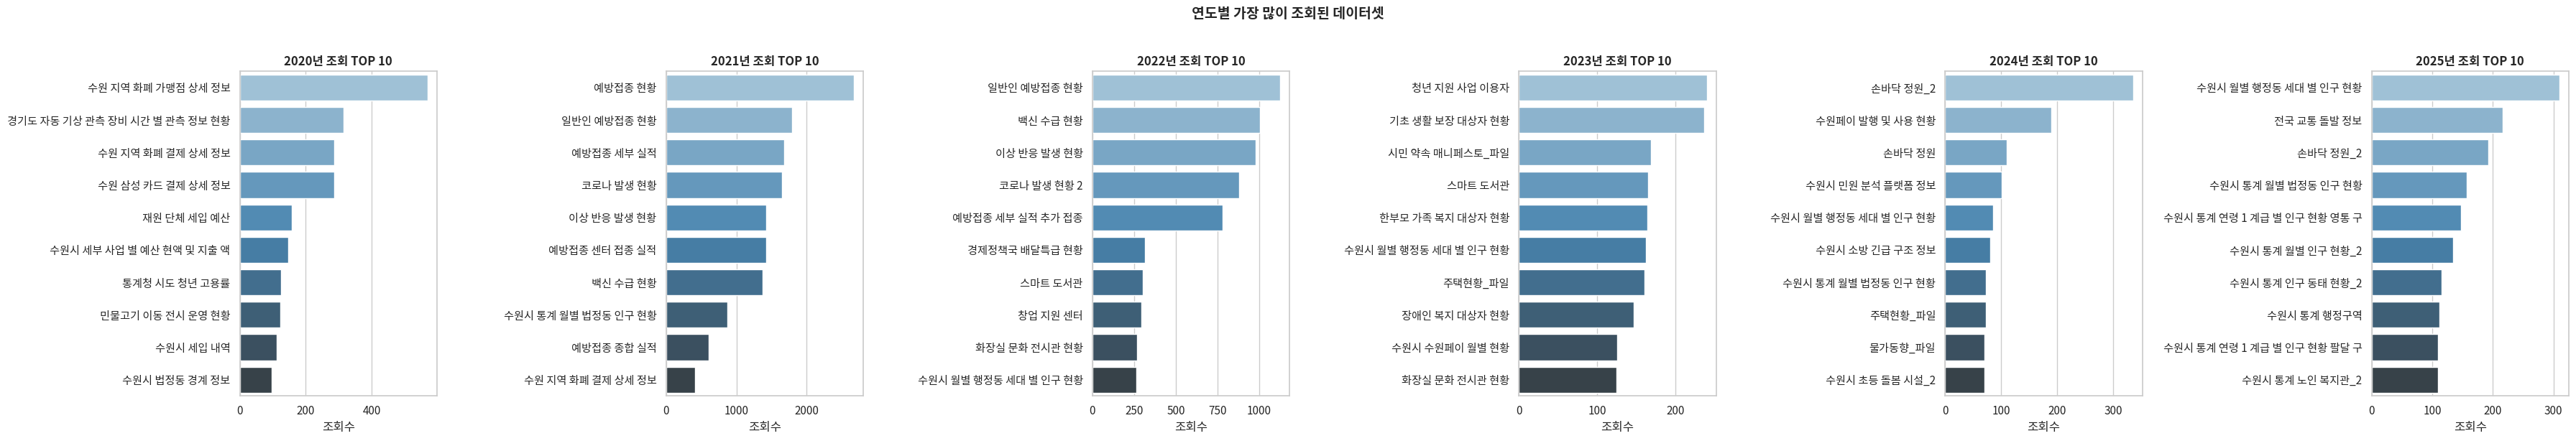

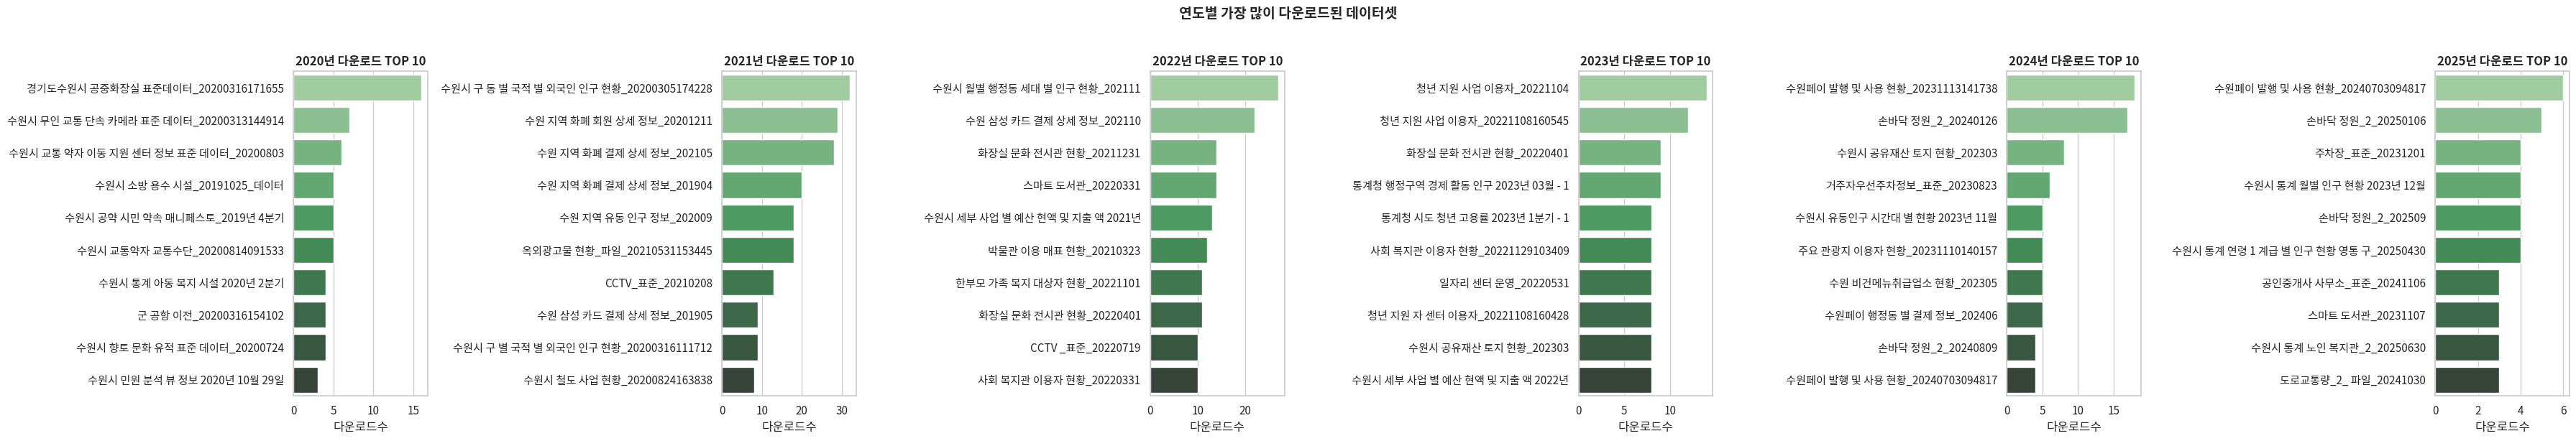

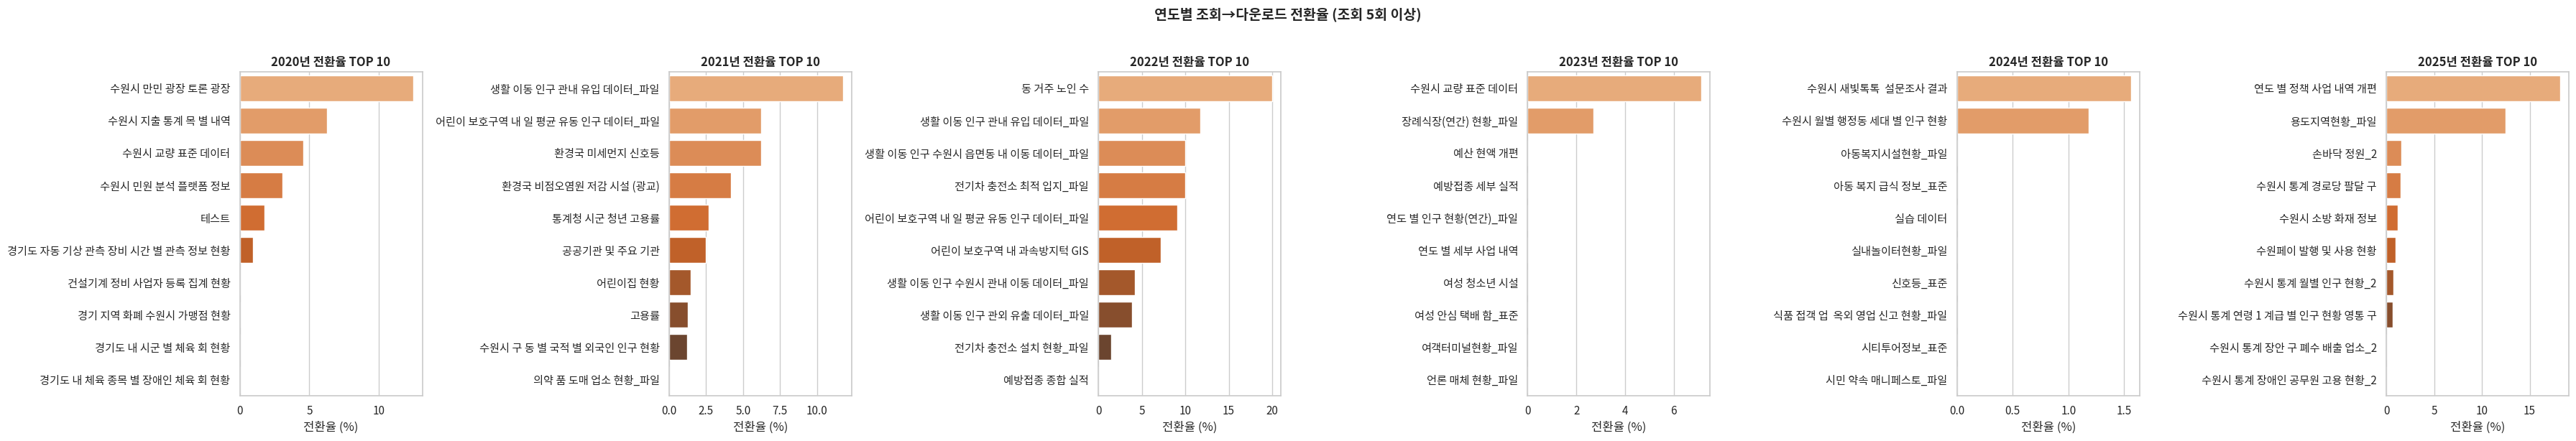

In [14]:
# ========================================
# 데이터셋별 접근/다운로드 분석 (연도별 Subplots)
# ========================================
import re

def extract_uuid(url):
    match = re.search(r'([a-f0-9]{8}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{12})', str(url))
    return match.group(1) if match else None

def classify_action(url):
    url_lower = str(url).lower()
    if 'download' in url_lower:
        return 'download'
    elif 'detail' in url_lower:
        return 'view'
    return 'other'

# 데이터 준비
df_analysis = df.copy()
df_analysis['extracted_id'] = df_analysis['page_url'].apply(extract_uuid)
df_analysis['action_type'] = df_analysis['page_url'].apply(classify_action)
df_analysis['year'] = df_analysis['issued'].dt.year.astype(str)

df_with_uuid = df_analysis[df_analysis['extracted_id'].notna()].copy()
rss_lookup = rss[['identifier', 'title']].drop_duplicates(subset='identifier')
df_with_uuid = df_with_uuid.merge(rss_lookup, left_on='extracted_id', right_on='identifier', how='left')

# Unknown 제외
df_known = df_with_uuid[df_with_uuid['title'].notna() & (df_with_uuid['title'].str.strip() != '')].copy()
df_known['dataset_name'] = df_known['title']

years = sorted(df_known['year'].unique())
n_years = len(years)

print(f'분석 대상 연도: {years}')
print(f'Known Dataset 로그: {len(df_known):,}건')
print()

# ========================================
# 1. 연도별 조회 TOP 10 (Subplots)
# ========================================
fig, axes = plt.subplots(1, n_years, figsize=(6*n_years, 6), sharey=False)
if n_years == 1:
    axes = [axes]

for ax, y in zip(axes, years):
    year_data = df_known[(df_known['year'] == y) & (df_known['action_type'] == 'view')]
    top = year_data['dataset_name'].value_counts().head(10)
    if len(top) > 0:
        sns.barplot(x=top.values, y=top.index, palette='Blues_d', ax=ax)
    ax.set_title(f'{y}년 조회 TOP 10', fontsize=12, fontweight='bold')
    ax.set_xlabel('조회수')
    ax.set_ylabel('')

plt.suptitle('연도별 가장 많이 조회된 데이터셋', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ========================================
# 2. 연도별 다운로드 TOP 10 (Subplots)
# ========================================
fig, axes = plt.subplots(1, n_years, figsize=(6*n_years, 6), sharey=False)
if n_years == 1:
    axes = [axes]

for ax, y in zip(axes, years):
    year_data = df_known[(df_known['year'] == y) & (df_known['action_type'] == 'download')]
    top = year_data['dataset_name'].value_counts().head(10)
    if len(top) > 0:
        sns.barplot(x=top.values, y=top.index, palette='Greens_d', ax=ax)
    else:
        ax.text(0.5, 0.5, 'No Downloads', ha='center', va='center', transform=ax.transAxes)
    ax.set_title(f'{y}년 다운로드 TOP 10', fontsize=12, fontweight='bold')
    ax.set_xlabel('다운로드수')
    ax.set_ylabel('')

plt.suptitle('연도별 가장 많이 다운로드된 데이터셋', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ========================================
# 3. 연도별 전환율 TOP 10 (Subplots)
# ========================================
fig, axes = plt.subplots(1, n_years, figsize=(6*n_years, 6), sharey=False)
if n_years == 1:
    axes = [axes]

for ax, y in zip(axes, years):
    year_data = df_known[df_known['year'] == y]
    view_counts = year_data[year_data['action_type'] == 'view'].groupby('dataset_name').size()
    download_counts = year_data[year_data['action_type'] == 'download'].groupby('dataset_name').size()
    
    conv_df = pd.DataFrame({'views': view_counts, 'downloads': download_counts}).fillna(0)
    conv_df['rate'] = (conv_df['downloads'] / conv_df['views'] * 100).round(2)
    conv_df = conv_df[conv_df['views'] >= 5].sort_values('rate', ascending=False).head(10)
    
    if len(conv_df) > 0:
        sns.barplot(x=conv_df['rate'].values, y=conv_df.index, palette='Oranges_d', ax=ax)
    else:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
    ax.set_title(f'{y}년 전환율 TOP 10', fontsize=12, fontweight='bold')
    ax.set_xlabel('전환율 (%)')
    ax.set_ylabel('')

plt.suptitle('연도별 조회→다운로드 전환율 (조회 5회 이상)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 6.1.1 데이터셋 접근/다운로드 인사이트

**🔍 연도별 조회 패턴 분석**
- 연도별 인기 데이터셋의 변화를 통해 사용자 관심사 트렌드 파악
- 지속적으로 인기 있는 데이터셋 vs 일시적 관심 데이터셋 구분 가능

**📥 다운로드 분석**
- 다운로드 수가 높은 데이터셋 = 실제 업무에 활용되는 핵심 데이터
- 조회는 많으나 다운로드가 낮은 경우: 데이터 품질/포맷 문제 가능성

**📊 전환율 해석**
- 전환율 높음: 해당 데이터셋이 사용자 니즈와 정확히 매칭
- 전환율 낮음: 제목과 내용 불일치, 데이터 품질 검토 필요
- 전환율 100% 이상: 동일 사용자의 반복 다운로드 (버전 업데이트 등)

### 6.2 퍼널(Funnel) 정의 및 시각화

서비스의 핵심 흐름을 다음과 같이 정의하여 분석합니다.

1. **로그인(Entrance)**: 서비스 접속
2. **리소스 탐색(Search)**: 데이터셋 또는 지표 목록 열람
3. **지표 상세 조회(View)**: 개별 지표 클릭
4. **데이터 활용(Action)**: 빅데이터 분석 또는 다운로드

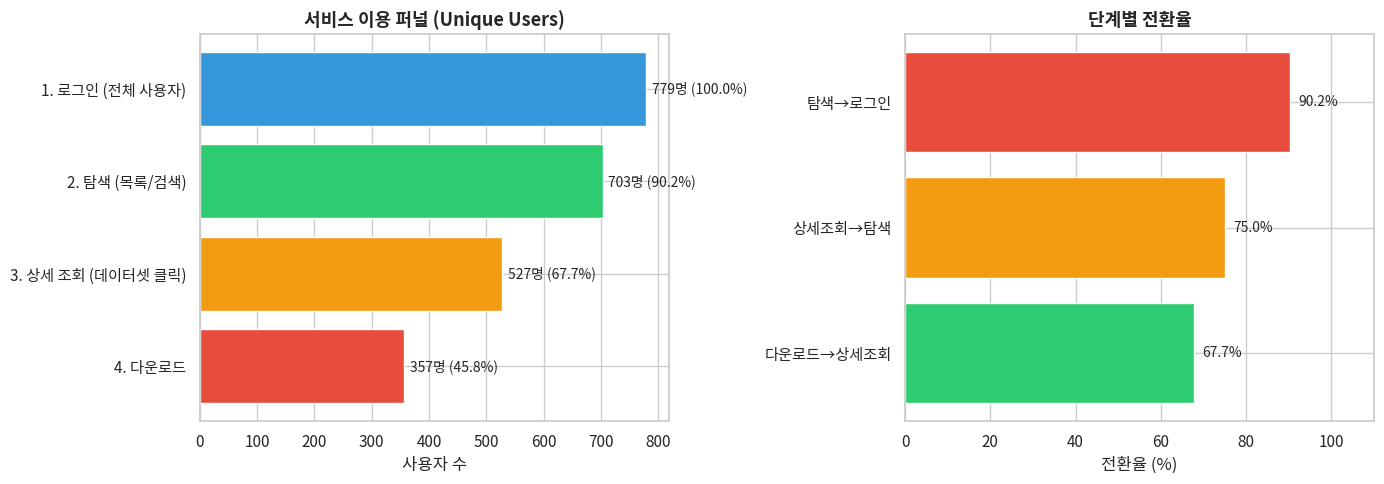

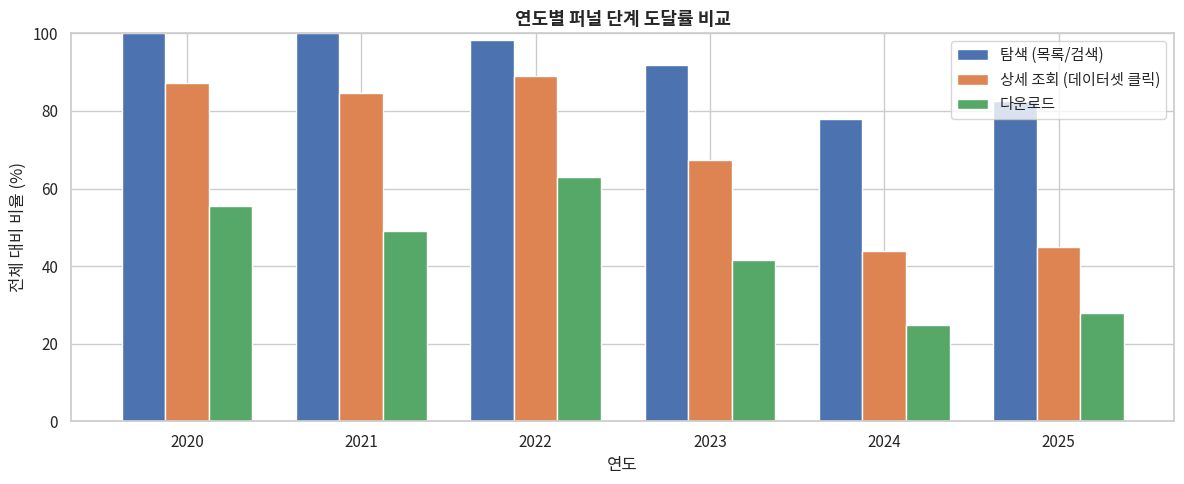

=== 전체 퍼널 요약 ===


,Step,Users,Overall_Rate,Step_Rate
0,1. 로그인 (전체 사용자),779,100.0,100.0
1,2. 탐색 (목록/검색),703,90.2,90.2
2,3. 상세 조회 (데이터셋 클릭),527,67.7,75.0
3,4. 다운로드,357,45.8,67.7


In [15]:
# ========================================
# 퍼널 분석 (상세)
# ========================================

def calculate_detailed_funnel(df, rss):
    """
    서비스 이용 퍼널 분석
    1. 로그인 (전체 사용자)
    2. 탐색 (목록/검색 페이지 접근)
    3. 상세 조회 (개별 데이터셋 클릭)
    4. 다운로드 (실제 데이터 다운로드)
    """
    import re
    
    def has_uuid(url):
        return bool(re.search(r'[a-f0-9]{8}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{12}', str(url)))
    
    # 단계별 사용자 수 계산
    total_users = df['user_id'].nunique()
    
    # 탐색: 목록, 리스트, 검색 관련 페이지
    explore_mask = (
        df['page_name'].str.contains('목록|리스트|검색|지표 조회|데이터셋', na=False, case=False) |
        df['page_url'].str.contains('/list|/search|/indicator', na=False, case=False)
    )
    explore_users = df[explore_mask]['user_id'].nunique()
    
    # 상세 조회: UUID가 포함된 detail URL
    detail_mask = df['page_url'].apply(has_uuid) & df['page_url'].str.contains('/detail', na=False, case=False)
    detail_users = df[detail_mask]['user_id'].nunique()
    
    # 다운로드
    download_mask = df['page_url'].str.contains('download', na=False, case=False)
    download_users = df[download_mask]['user_id'].nunique()
    
    funnel_data = [
        ('1. 로그인 (전체 사용자)', total_users),
        ('2. 탐색 (목록/검색)', explore_users),
        ('3. 상세 조회 (데이터셋 클릭)', detail_users),
        ('4. 다운로드', download_users)
    ]
    
    funnel_df = pd.DataFrame(funnel_data, columns=['Step', 'Users'])
    funnel_df['Overall_Rate'] = (funnel_df['Users'] / total_users * 100).round(1)
    funnel_df['Step_Rate'] = funnel_df['Users'].pct_change().apply(
        lambda x: round((1+x)*100, 1) if pd.notnull(x) else 100.0
    )
    
    return funnel_df

# 전체 퍼널
funnel_all = calculate_detailed_funnel(df, rss)

# 시각화: 전체 퍼널
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 왼쪽: 절대 사용자 수
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
bars = axes[0].barh(funnel_all['Step'][::-1], funnel_all['Users'][::-1], color=colors[::-1])
axes[0].set_title('서비스 이용 퍼널 (Unique Users)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('사용자 수')
for i, (v, r) in enumerate(zip(funnel_all['Users'][::-1], funnel_all['Overall_Rate'][::-1])):
    axes[0].text(v + 10, i, f'{v:,}명 ({r}%)', va='center', fontsize=10)

# 오른쪽: 단계별 전환율
step_rates = funnel_all['Step_Rate'].values[1:]  # 첫 번째는 100%이므로 제외
step_labels = ['탐색→로그인', '상세조회→탐색', '다운로드→상세조회']
axes[1].barh(step_labels[::-1], step_rates[::-1], color=['#2ecc71', '#f39c12', '#e74c3c'])
axes[1].set_title('단계별 전환율', fontsize=13, fontweight='bold')
axes[1].set_xlabel('전환율 (%)')
axes[1].set_xlim(0, 110)
for i, v in enumerate(step_rates[::-1]):
    axes[1].text(v + 2, i, f'{v}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# 연도별 퍼널 비교
df['year'] = df['issued'].dt.year.astype(str)
years = sorted(df['year'].unique())

yearly_funnels = {}
for y in years:
    yearly_funnels[y] = calculate_detailed_funnel(df[df['year'] == y], rss)

# 연도별 전환율 비교 차트
fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(years))
width = 0.25

for i, step in enumerate(['2. 탐색 (목록/검색)', '3. 상세 조회 (데이터셋 클릭)', '4. 다운로드']):
    rates = [yearly_funnels[y][yearly_funnels[y]['Step'] == step]['Overall_Rate'].values[0] for y in years]
    ax.bar(x + i*width, rates, width, label=step.split('. ')[1])

ax.set_ylabel('전체 대비 비율 (%)')
ax.set_xlabel('연도')
ax.set_title('연도별 퍼널 단계 도달률 비교', fontsize=13, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(years)
ax.legend()
ax.set_ylim(0, 100)
plt.tight_layout()
plt.show()

print('=== 전체 퍼널 요약 ===')
display(funnel_all)

### 6.2.1 퍼널 분석 인사이트

**📊 핵심 지표**
- **탐색→로그인 전환율**: 로그인 사용자 중 실제 데이터 탐색 비율
- **상세조회→탐색 전환율**: 탐색 사용자 중 특정 데이터셋 클릭 비율
- **다운로드→상세조회 전환율**: 상세 조회 후 실제 다운로드 비율

**🎯 개선 포인트**
1. **탐색 전환율 낮음**: 홈페이지 UX 개선, 추천 시스템 도입 검토
2. **상세조회 전환율 낮음**: 검색 기능 개선, 카테고리 구조 재설계
3. **다운로드 전환율 낮음**: 데이터 포맷/품질 개선, 다운로드 절차 간소화

**📈 연도별 트렌드**
- 연도별 전환율 변화를 통해 서비스 개선 효과 측정 가능
- 특정 연도에 급격한 변화가 있다면 해당 시점의 서비스 변경사항 확인

### 6.3 퍼널 분석 결과 및 인사이트

- **최대 이탈 구간**: 어느 단계에서 가장 많은 유저가 이탈하는지 확인 (예: 2->3단계)
- **전략적 제안**: 발견된 병목 구간의 UX 개선 또는 기능 노출 강화 필요